# Experiments for Bachelor's Program in Business Informatics University of Mannheim
This notebook contains the experiments performed on the bachelor's program in business informatics of the University of Mannheim

## 1. Imports

In [1]:
import camelot
import pandas as pd
import tableExtraction as te
import graphCreation as gc
import re
import networkx as nx
import matplotlib.pyplot as plt

## 2. Create Graph
### 2.1 Extract Course Tables from Module Handbooks

In [2]:
relevant_courses = te.get_relevant_courses("../02_Ressources/MK_BSc_Wifo_2020_21_Course_Overview.pdf")
courses = te.get_courses("../02_Ressources/MK_BSc_Wifo_2020_21_Courses.pdf")


paths = ["../02_Ressources/Modulkatalog_Nebenfach_BWL.pdf", "../02_Ressources/MK_BSc_Wima_2020_21.pdf"]
end_cells = ["Verwendbarkeit", "Einordnung in Fachsemester"]
coordinates = [[0,0],[0,1]]
courses.extend(te.get_additional_courses(relevant_courses, paths, end_cells, coordinates))

C:\Users\Paul\anaconda3\envs\master_thesis\lib\site-packages\camelot\utils.py:740: UserWarning:   (541.47, 544.182) does not lie in column range (65.52538683491369, 541.3654737903225)
  warnings.warn(
C:\Users\Paul\anaconda3\envs\master_thesis\lib\site-packages\camelot\utils.py:740: UserWarning:   (541.47, 544.182) does not lie in column range (65.52547473292196, 541.3654737903225)
  warnings.warn(
C:\Users\Paul\anaconda3\envs\master_thesis\lib\site-packages\camelot\utils.py:740: UserWarning:   (535.58, 538.292) does not lie in column range (71.03522406889036, 535.0440545877398)
  warnings.warn(
C:\Users\Paul\anaconda3\envs\master_thesis\lib\site-packages\camelot\utils.py:740: UserWarning:     (535.58, 538.292) does not lie in column range (71.03147798266829, 535.0440548166061)
  warnings.warn(
C:\Users\Paul\anaconda3\envs\master_thesis\lib\site-packages\camelot\utils.py:740: UserWarning:   (535.58, 538.292) does not lie in column range (71.03147798266829, 535.0440548166061)
  warnings

In [26]:
#export courses
courses = te.post_fixes(courses)

index = 0
for course in courses:
    name = "../03_Courses/" + "Course" + str(index) + ".xlsx"
    course.to_excel(name, index=False)
    index += 1

In [28]:
#import courses

courses = []
for i in range(0,54):
    #Exclude the international courses
    #if not (i == 16) and not (i == 24):
    path = "../03_Courses/Course" + str(i) + ".xlsx"
    df = pd.read_excel(path, dtype=str).fillna('')
    courses.append(df)

### 2.2 Creation of Nodes & Edges

In [29]:
G = nx.DiGraph()

course_nodes = gc.getCourseNodes(courses)
knowledge_nodes = pd.read_excel("../04_Graph/knowledgeAreas.xlsx").values.tolist()
edges_df = pd.read_excel("../04_Graph/edges.xlsx")
edges = edges_df.values.tolist()

In [30]:
#Create Course Nodes
for node in course_nodes:
    G.add_node(node[0], ECTS=node[1], offering_cycle=node[2], color="grey", type="course", active = False)

#Create Skill Nodes
for i in range(len(knowledge_nodes)):
    if i <= 16:
        G.add_node(knowledge_nodes[i][0], color="blue", type="skill", active = False)
    elif i > 16 and i <= 22:
        G.add_node(knowledge_nodes[i][0], color="green", type="skill", active = False)
    else:
        G.add_node(knowledge_nodes[i][0], color="brown", type="skill", active = False)

#print(G.nodes)

In [31]:
#Load manually created course -> skill edges
for edge in edges:
   G.add_edge(edge[0], edge[1], active = False)

additional_edges, additional_nodes = gc.complete_edges(courses, edges_df)

for node in additional_nodes:
    G.add_node(node[0], color = node[1], type = node[2], subtype = node[3], active = False)

for edge in additional_edges:
    if len(edge) <= 2:
        G.add_edge(edge[0], edge[1], active = False)
    else:
        G.add_edge(edge[0], edge[1], weight = edge[2], active = False)

In [32]:
#Quality Checks for Attribute values

for node, data in G.nodes(data=True):
    print(f"Knoten {node}: name = {data.get('offering_cycle')}")
    #print(data.get('ECTS'))
    #if not (data.get('offering_cycle') == "FWS" or data.get('offering_cycle') =="SSS" or data.get('offering_cycle') == "Continuously"):
        #print(f"Knoten {node}: name = {data.get('offering_cycle')}")
    #print(f"Knoten {node}: name = {data.get('ECTS')}")

#for outgoing, ingoing, data in G.edges(data=True):
#    print(f"{outgoing} -> {ingoing}: weight = {data.get('weight')}")

#for outgoing, ingoing, data in G.edges(data=True):
    #if not data.get("weight") == None:
        #print(f"{outgoing} -> {ingoing}: weight = {data.get('ECTS')}")
    #print(data.get('ECTS'))

Knoten IS 201 Wirtschaftsinformatik I: Einführung und Grundlagen Business Informatics I: Introduction and Foundations: name = FWS
Knoten IS 202a Wirtschaftsinformatik IIa: Einführung in die Modellierung I: Logik Business Informatics IIa: Foundations of Modeling I: logic: name = SSS
Knoten IS 202b Wirtschaftsinformatik IIb: Einführung in die Modellierung II: Prozessmodelle Business Informatics IIb: Foundations of Modeling II: process models: name = SSS
Knoten IS 203 Wirtschaftsinformatik III: Development and Management of Information Systems Business Informatics III: Development and Management of Information Systems: name = FWS
Knoten IS 204 Wirtschaftsinformatik IV Business Informatics IV: name = SSS
Knoten CS 301 Formale Grundlagen der Informatik Formal Foundations of Computer Science: name = FWS
Knoten CS 302 Praktische Informatik I Practical Computer Science I: name = FWS
Knoten CS 303 Praktische Informatik II Practical Computer Science II: name = SSS
Knoten CS 304 Programmierprakti

<function matplotlib.pyplot.show(close=None, block=None)>

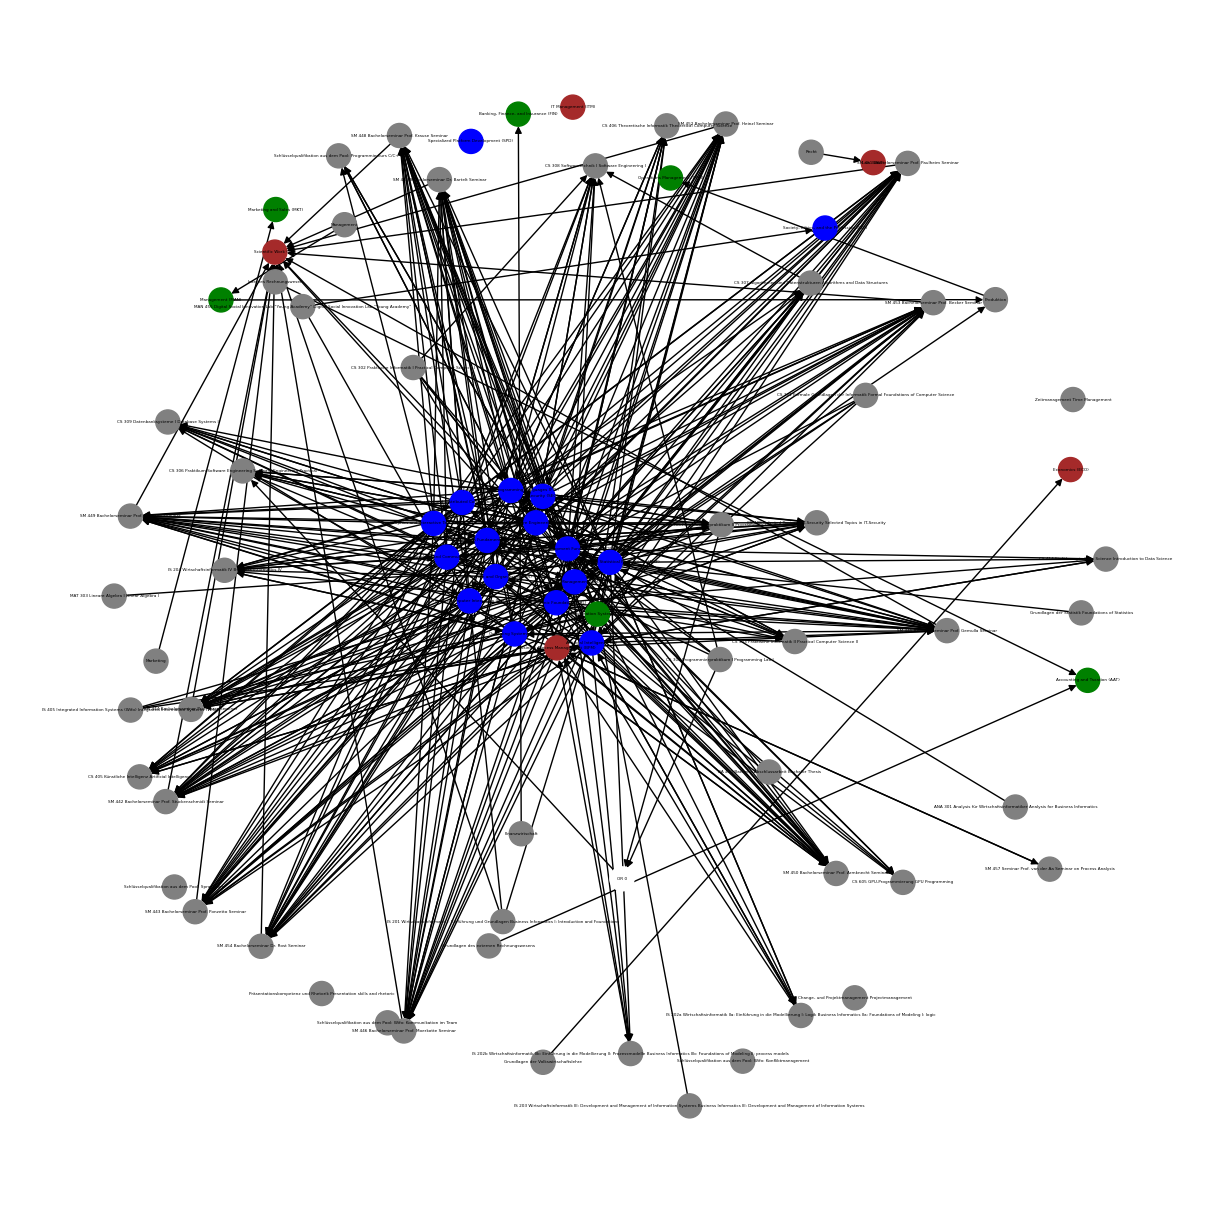

In [18]:
pos = nx.spring_layout(G, k=1) 

plt.figure(figsize=(12, 12))

node_colors = [G.nodes[node]['color'] for node in G.nodes()]

nx.draw(G, pos, with_labels=True, node_color=node_colors, font_size=3)

#nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)
plt.savefig("graph.pdf", format="pdf") 
plt.show

### 2.2 Creation of Knowledge Areas

In [13]:
#append knowledge field for analysis

#fields containing information about knowledge areas
fields = ["Lehrinhalte", "Lern- und Kompetenzziele", "Lern- und Qualifikationsziele", "Vorausgesetzte Kenntnisse"]
courses = te.append_raw_knowledge_field(fields, courses)

In [14]:
#combine all raw_knowledge_fields

raw_knowledge_combined = ""
for course in courses:
    raw_knowledge_combined += course.iloc[len(course)-1,1] + " "

cleaned_raw_knowledge_combined = re.sub(r'\s*-\s*', ' ', raw_knowledge_combined).replace('-', '')


NameError: name 'nlp' is not defined

In [17]:
from transformers import pipeline

# NER Pipeline laden
ner_pipeline = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")

# Skills im Text extrahieren
ner_results = ner_pipeline(cleaned_raw_knowledge_combined)
print(ner_results)
skills = [result['word'] for result in ner_results if result['entity'] == 'I-MISC']

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'entity': 'I-MISC', 'score': 0.5857197, 'index': 47, 'word': 'W', 'start': 126, 'end': 127}, {'entity': 'I-MISC', 'score': 0.53814673, 'index': 49, 'word': '##sch', 'start': 130, 'end': 133}, {'entity': 'I-MISC', 'score': 0.8541129, 'index': 188, 'word': 'Ben', 'start': 521, 'end': 524}, {'entity': 'I-MISC', 'score': 0.4742797, 'index': 243, 'word': '##aft', 'start': 671, 'end': 674}, {'entity': 'I-MISC', 'score': 0.6192035, 'index': 257, 'word': 'Information', 'start': 711, 'end': 722}, {'entity': 'I-ORG', 'score': 0.60637033, 'index': 327, 'word': 'Ke', 'start': 898, 'end': 900}, {'entity': 'I-ORG', 'score': 0.41567594, 'index': 328, 'word': '##ine', 'start': 900, 'end': 903}, {'entity': 'I-ORG', 'score': 0.44517997, 'index': 368, 'word': 'Roll', 'start': 1007, 'end': 1011}, {'entity': 'I-MISC', 'score': 0.57943016, 'index': 381, 'word': 'W', 'start': 1047, 'end': 1048}]


In [11]:
print(skills)

['Python']
